In [1]:
# === SEKCJA 1: IMPORT I KONFIGURACJA ===
import pandas as pd
import numpy as np
import re
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from IPython.display import display
import matplotlib.pyplot as plt

print("Wczytywanie danych...")
df_main = pd.read_csv('data.csv', sep=',')
df_ulic = pd.read_csv('Ulic.csv', sep=',')
print("Wszystkie pliki wczytane.")

Wczytywanie danych...


C:\Users\Ai\AppData\Local\Temp\ipykernel_16344\2410156554.py:19: DtypeWarning: Columns (15,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv('data.csv', sep=',')


Wszystkie pliki wczytane.


In [2]:
# === SEKCJA 2: PRZYGOTOWANIE DANYCH ===
df_ulic.rename(columns={'Name': 'NAZWA_ULICY'}, inplace=True)
df_ulic.dropna(subset=['SymUl', 'NAZWA_ULICY'], inplace=True)
street_dictionary = pd.Series(df_ulic.NAZWA_ULICY.values, index=df_ulic.SymUl).to_dict()

df_processed = df_main.copy()
df_processed.dropna(subset=['Area', 'Price', 'Description', 'Location', 'StreetNumber'], inplace=True)

def process_location(row):
    location_str, district, street = row['Location'], np.nan, np.nan
    if isinstance(location_str, str):
        parts = [p.strip() for p in location_str.split(',')]
        if len(parts) >= 3 and 'warszawa' in parts[1].lower(): district = parts[2]
    if pd.notna(row['StreetNumber']):
        try:
            street_sym = int(row['StreetNumber'])
            if street_sym in street_dictionary: street = street_dictionary[street_sym]
        except (ValueError, TypeError): pass
    if pd.isna(street) and isinstance(location_str, str) and len(location_str.split(',')) >= 4:
        street = location_str.split(',')[3].strip()
    if isinstance(street, str):
        street = re.sub(r'^(ul\.|al\.|pl\.)\s*', '', street, flags=re.IGNORECASE).lower()
        if len(street) < 3: street = np.nan
    return pd.Series([district, street])

df_processed[['District', 'Ulica_clean']] = df_processed.apply(process_location, axis=1)
df_processed.dropna(subset=['Ulica_clean', 'District'], inplace=True)

MIN_SAMPLES_PER_STREET = 25
street_counts = df_processed['Ulica_clean'].value_counts()
streets_to_remove = street_counts[street_counts < MIN_SAMPLES_PER_STREET].index
df_model_ready = df_processed[~df_processed['Ulica_clean'].isin(streets_to_remove)].copy()
print(f"Finalny zbiór danych gotowy. Wiersze: {len(df_model_ready)}, Ulice: {df_model_ready['Ulica_clean'].nunique()}")

Finalny zbiór danych gotowy. Wiersze: 52543, Ulice: 682


In [3]:
# === SEKCJA 3: INŻYNIERIA CECH DO SIECI NEURONOWEJ ===
def clean_text(text): return re.sub(r'[^a-ząęółśżźćń ]', '', str(text).lower())
df_model_ready['description_clean'] = df_model_ready['Description'].apply(clean_text)

MAX_WORDS, MAX_LEN = 20000, 200
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_model_ready['description_clean'])
sequences = tokenizer.texts_to_sequences(df_model_ready['description_clean'])
X_text = pad_sequences(sequences, maxlen=MAX_LEN)

numeric_features = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors']
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
X_numeric = numeric_pipeline.fit_transform(df_model_ready[numeric_features])

categorical_features = ['District', 'BuildingType']
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
X_categorical = cat_pipeline.fit_transform(df_model_ready[categorical_features])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_model_ready['Ulica_clean'])
num_classes = len(label_encoder.classes_)
print("Dane przygotowane do treningu.")

Dane przygotowane do treningu.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 200, 128)          │       2,560,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 256)               │         263,168 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ categorical_input             │ (None, 37)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 298)               │               0 │ bidirectional[0][0],       │
│                               │                           │                 │ numeric_input[0][0],       │
│                               │                           │                 │ categorical_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │         153,088 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512)               │           2,048 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │         131,328 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256)               │           1,024 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 682)               │         175,274 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,285,930 (12.53 MB)

 Trainable params: 3,284,394 (12.53 MB)

 Non-trainable params: 1,536 (6.00 KB)


Rozpoczynam trening sieci neuronowej (wersja z Bidirectional LSTM)...
Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 166s 981ms/step - accuracy: 0.0722 - loss: 5.6043 - val_accuracy: 0.0914 - val_loss: 5.5519 - learning_rate: 0.0010
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 155s 938ms/step - accuracy: 0.1722 - loss: 3.5509 - val_accuracy: 0.1884 - val_loss: 4.4119 - learning_rate: 0.0010
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 148s 898ms/step - accuracy: 0.2235 - loss: 3.2017 - val_accuracy: 0.2513 - val_loss: 3.3040 - learning_rate: 0.0010
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 140s 845ms/step - accuracy: 0.2751 - loss: 2.8813 - val_accuracy: 0.3141 - val_loss: 2.8055 - learning_rate: 0.0010
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 141s 855ms/step - accuracy: 0.3424 - loss: 2.5837 - val_accuracy: 0.3428 - val_loss: 2.5902 - learning_rate: 0.0010
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 142s 860ms/step - accuracy: 0.4129 - loss: 2.2580 - val_accuracy: 0.3859 - val_loss: 2.4555 - learning_rate: 

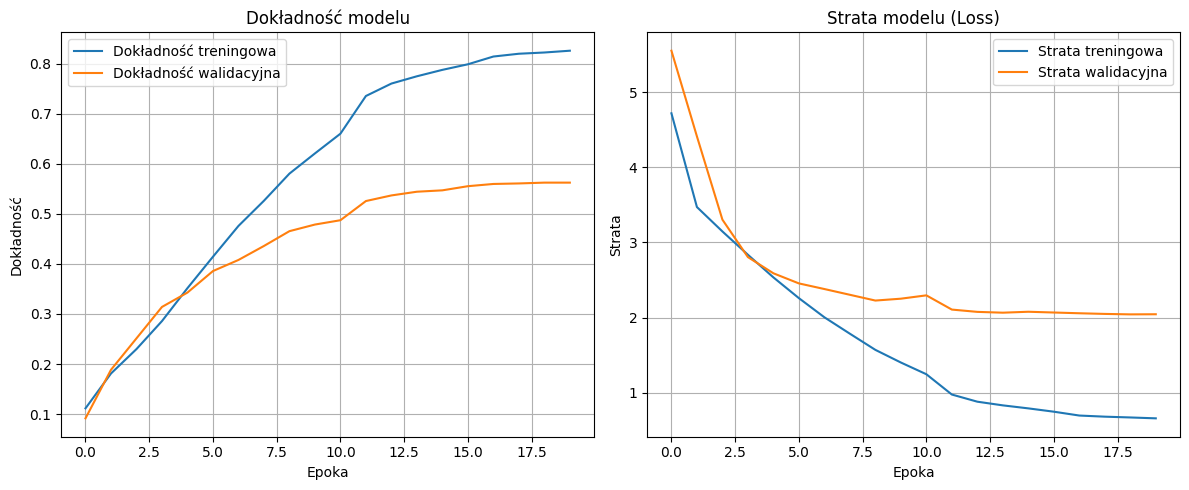

In [4]:
# === SEKCJA 4: BUDOWA I TRENING - WERSJA ULEPSZONA v2 (Rekomendowana) ===

# Dodatkowy import dla warstwy dwukierunkowej
from tensorflow.keras.layers import Bidirectional

# Definicja architektury z Bidirectional LSTM
input_text = Input(shape=(MAX_LEN,), name='text_input')
input_numeric = Input(shape=(X_numeric.shape[1],), name='numeric_input')
input_categorical = Input(shape=(X_categorical.shape[1],), name='categorical_input')

embedding_layer = Embedding(input_dim=MAX_WORDS, output_dim=128)(input_text)
# ZASTOSOWANIE BIDIRECTIONAL LSTM
lstm_layer = Bidirectional(LSTM(128, dropout=0.2))(embedding_layer)
concatenated = Concatenate()([lstm_layer, input_numeric, input_categorical])

# Powrót do oryginalnych warstw gęstych (bez L2 i z mniejszym dropoutem)
x = Dense(512, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[input_text, input_numeric, input_categorical], outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Podział i trening
X_train_text, X_val_text, X_train_num, X_val_num, X_train_cat, X_val_cat, y_train, y_val = train_test_split(
    X_text, X_numeric, X_categorical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

print("\nRozpoczynam trening sieci neuronowej (wersja z Bidirectional LSTM)...")
# Zapisujemy wyniki do zmiennej 'history'
history = model.fit(
    [X_train_text, X_train_num, X_train_cat], y_train,
    validation_data=([X_val_text, X_val_num, X_val_cat], y_val),
    epochs=20,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr]
)

# Zapis modelu
model.save('street_predictor_final_v3.keras') # Zapisuję jako v3
print("\nModel został wytrenowany i zapisany jako 'street_predictor_final_v3.keras'.")

# Wizualizacja
print("\nGenerowanie wykresów uczenia...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata modelu (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
# === SEKCJA 5: PREDYKCJA NA CAŁEJ BAZIE I WZBOGACENIE DANYCH ===
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

print("Przygotowywanie całego zbioru danych do predykcji...")

# Stworzenie kopii oryginalnego zbioru danych
df_predict_base = df_main.copy()

# 1. Stosowanie tych samych transformacji, co na zbiorze treningowym
df_predict_base[['District', 'Ulica_clean']] = df_predict_base.apply(process_location, axis=1)
df_predict_base['description_clean'] = df_predict_base['Description'].apply(clean_text)

# Wypełnienie braków w danych, które mogą powodować błędy w pipeline'ach
df_predict_base['description_clean'].fillna('brak opisu', inplace=True)
for col in numeric_features:
    df_predict_base[col].fillna(0, inplace=True)
for col in categorical_features:
    df_predict_base[col].fillna('missing', inplace=True)

# 2. Transformacja danych przy użyciu WYTRENOWANYCH pipeline'ów i tokenizera
sequences_pred = tokenizer.texts_to_sequences(df_predict_base['description_clean'])
X_text_full = pad_sequences(sequences_pred, maxlen=MAX_LEN)
X_numeric_full = numeric_pipeline.transform(df_predict_base[numeric_features])
X_categorical_full = cat_pipeline.transform(df_predict_base[categorical_features])

print("Generowanie predykcji dla całego zbioru danych...")
# 3. Predykcja
predictions_proba = model.predict([X_text_full, X_numeric_full, X_categorical_full])
predicted_labels_encoded = np.argmax(predictions_proba, axis=1)
predicted_street_names = label_encoder.inverse_transform(predicted_labels_encoded)
predicted_probabilities = np.max(predictions_proba, axis=1)

# 4. Dodanie wyników do DataFrame
df_predict_base['Predicted_Ulica'] = predicted_street_names
df_predict_base['Predicted_Ulica_Prob'] = predicted_probabilities

print("Predykcja zakończona. Dane zostały wzbogacone.")

# 5. Wyświetlanie przykładowych wyników (z dodanymi kolumnami SaleId i District)
print("\nPrzykładowe 25 losowych wierszy z uzupełnionymi danymi:")
display_cols = ['SaleId', 'Location', 'District', 'Predicted_Ulica', 'Predicted_Ulica_Prob', 'Price', 'Area', 'Description']
display(df_predict_base[display_cols].sample(25, random_state=42))

# 6. Zapis do pliku CSV
output_filename = 'data_with_predicted_streets_v3.csv'
df_predict_base.to_csv(output_filename, index=False, sep=',')
print(f"\nFinalny DataFrame ({len(df_predict_base)} wierszy) zapisano do pliku: {output_filename}")

Przygotowywanie całego zbioru danych do predykcji...
Generowanie predykcji dla całego zbioru danych...
6133/6133 ━━━━━━━━━━━━━━━━━━━━ 317s 52ms/step
Predykcja zakończona. Dane zostały wzbogacone.

Przykładowe 25 losowych wierszy z uzupełnionymi danymi:


,SaleId,Location,District,Predicted_Ulica,Predicted_Ulica_Prob,Price,Area,Description
117971,3306651,"Mazowieckie, Warszawa, Mokotów, Ul. Polska",Mokotów,polska,0.994731,992250.0,55.90,3-pokojowe mieszkanie numer EC 0001 na parterz...
105430,3136257,"Mazowieckie, Warszawa, Białołęka, Ul. Winorośli",Białołęka,książkowa,0.336446,0.0,50.00,3-pokojowe mieszkanie numer 85 na 3. piętrze w...
130903,3506482,"Mazowieckie, Warszawa, Mokotów, Ksawerów",Mokotów,wołoska,0.740929,1904000.0,83.95,Certyfikowane Osiedle o Wysokim Standardzie z ...
180140,4249856,"Mazowieckie, Grodziski, Grodzisk Mazowiecki",missing,bednarska,0.201660,699000.0,55.00,"Mieszkanie, Grodzisk Mazowiecki, 55 m² Ogłosze..."
73766,2760208,"Mazowieckie, Warszawa, Bemowo, Ul. Strońska",Bemowo,dywizjonu 303,0.397142,850000.0,66.70,Mieszkanie: Mieszkanie składa się z przestronn...
85493,2889192,"Mazowieckie, Radomski, Zakrzew, Bielicha",missing,nowolipie,0.122732,299000.0,67.50,Mieszkanie os. Nowe Panty Radom. Cena 299 tys....
19147,913358,"Mazowieckie, Warszawa, Ursus, Ul. Przy Forcie",Ursus,tomcia palucha,0.887887,0.0,49.74,Najważniejsze atuty ✅ Bogata infrastruktura mi...
139381,3652415,"Mazowieckie, Warszawa, Praga-południe, Ul. Pol...",Praga-południe,gen. tadeusza bora-komorowskiego,0.683727,865000.0,51.10,Zapraszamy do zapoznania się z przytulnym mies...
20811,954853,"Mazowieckie, Warszawa, Ursus, Ul. Szamoty",Ursus,herbu oksza,0.588320,0.0,54.76,2-pokojowe mieszkanie numer D_152 na parterze ...
143413,3713496,"Mazowieckie, Legionowski, Legionowo, Ul. Husarska",missing,odkryta,0.079633,525000.0,54.00,Legionowo ulica Husarska - 54m2 | 3 pokoje | P...



Finalny DataFrame (196240 wierszy) zapisano do pliku: data_with_predicted_streets_v3.csv
